<a href="https://colab.research.google.com/github/asishpattnaik1/CE888/blob/main/Final_Project/TweetEvalClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import important libraries

In [47]:
import pandas as pd
import numpy as np
import urllib.request
import csv
import matplotlib.pyplot as plt

In [63]:
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

In [64]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

Selected datasets are: **Offensive language identification** , **Hate speech detection** and **Emotion Recognition.**

Loading Hate Datasets 

In [65]:
#loading Hate speech data
#Loading Train dataset
hate_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_train_text.columns= ["tweet_text"]
hate_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt",encoding='utf-8',sep="\n", header=None)
hate_train_label.columns= ["tweet_label"]

# Loading Validation dataset
hate_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_val_text.columns= ["tweet_text"]
hate_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_val_label.columns= ["tweet_label"]

# Loading Test dataset
hate_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_text.columns= ["tweet_text"]
hate_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_test_label.columns= ["tweet_label"]

# Loading Map
hate_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt",encoding='utf-8',sep="\t", header=None)
hate_map.columns= ["tweet_label","isHate"]


Loading Offensive Datasets

In [66]:
#loading offensive data
#Loading Train dataset
off_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt",encoding='utf-8',sep="\t", header=None)
off_train_text.columns= ["tweet_text"]
off_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt",encoding='utf-8',sep="\t", header=None)
off_train_label.columns= ["tweet_label"]

# Loading Validation dataset
off_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt",encoding='utf-8',sep="\t", header=None)
off_val_text.columns= ["tweet_text"]
off_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt",encoding='utf-8',sep="\t", header=None)
off_val_label.columns= ["tweet_label"]

# Loading Test dataset
off_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt",encoding='utf-8',sep="\t", header=None)
off_test_text.columns= ["tweet_text"]
off_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt",encoding='utf-8',sep="\t", header=None)
off_test_label.columns= ["tweet_label"]

#loading Map Dataset
off_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/mapping.txt",encoding='utf-8',sep="\t", header=None)
off_map.columns= ["tweet_label","offensive"]


Loading Emotion Recognition Datasets

In [67]:
#loading Emotion data
#Loading Train dataset
emo_train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt",encoding='utf-8',sep="\t", header=None)
emo_train_text.columns= ["tweet_text"]
emo_train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_train_label.columns= ["tweet_label"]

# Loading Validation dataset
emo_val_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt",encoding='utf-8',sep="\t", header=None)
emo_val_text.columns= ["tweet_text"]
emo_val_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_val_label.columns= ["tweet_label"]

# Loading Test dataset
emo_test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt",encoding='utf-8',sep="\t", header=None)
emo_test_text.columns= ["tweet_text"]
emo_test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt",encoding='utf-8',sep="\t", header=None)
emo_test_label.columns= ["tweet_label"]

# Loading map dataset
emo_map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt",encoding='utf-8',sep="\t", header=None)
emo_map.columns= ["tweet_label","emotion"]



# **Hate Detection**
## Pre-processing

In [68]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_hate_train = pd.concat([hate_train_text,hate_train_label], axis=1)
df_hate_val = pd.concat([hate_val_text,hate_val_label], axis=1)
df_hate_test = pd.concat([hate_test_text,hate_test_label], axis=1)

In [69]:
hate_combo_train = pd.merge(df_hate_train,hate_map, on='tweet_label')
hate_combo_val = pd.merge(df_hate_val,hate_map, on='tweet_label')
hate_combo_test = pd.merge(df_hate_test,hate_map, on='tweet_label')

hate_train_val = pd.concat([hate_combo_train, hate_combo_val])

#checking total nan values/ empty rows
total =0
for n in pd.isna(hate_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

8

In [70]:
hate_train_val.dropna(inplace=True) #dropping the empty tweets, total 8, as they were included during the reading part
hate_combo_test.dropna(inplace=True)

**Visualization**

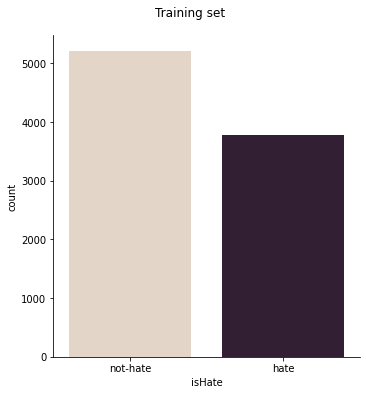

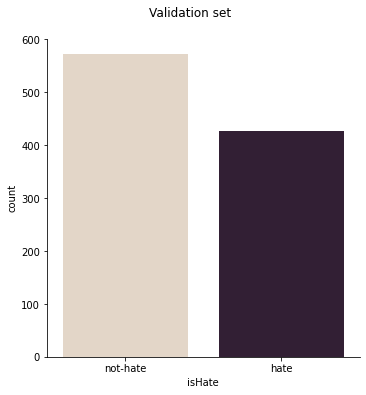

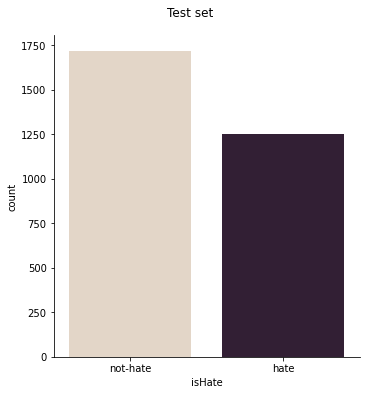

In [71]:
g = (sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("hate_train.png")
# files.download("hate_train.png")
plt.show()

v = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("hate_val.png")
# files.download("hate_val.png")
plt.show()

t = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("hate_test.png")
# files.download("hate_test.png")
plt.show()

In [72]:
#creating different datasets for different emotions for hate
from google.colab import files
hate_yes = hate_train_val[hate_train_val['isHate'] == 'hate']['tweet_text']
hate_no =  hate_train_val[hate_train_val['isHate'] == 'not-hate']['tweet_text']

wordcloud

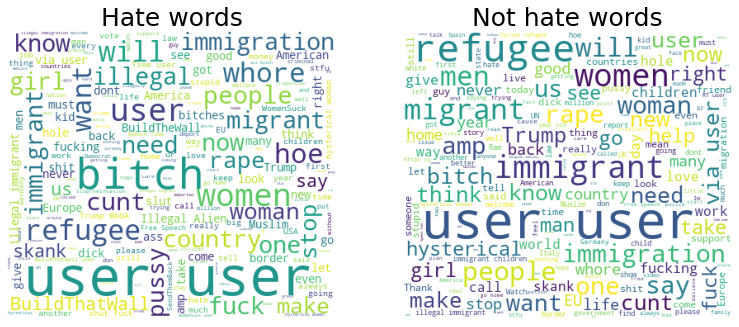

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[13, 13])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(hate_yes))
#wordcloud1.to_file('hate_cloud.png')
#files.download('hate_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Hate words',fontsize=25);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(hate_no))
#wordcloud2.to_file('not_hate_cloud.png')
#files.download('not_hate_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not hate words',fontsize=25);

In [74]:
# Source of code: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Top Hate and not hate word  Bar graph

In [75]:
top_hate_words = get_top_n_words(hate_yes)
top_nonHate_words = get_top_n_words(hate_no)


h1 = [x[0] for x in top_hate_words[:20]]
h2 = [x[1] for x in top_hate_words[:20]]

nh1 = [x[0] for x in top_nonHate_words[:20]]
nh2 = [x[1] for x in top_nonHate_words[:20]]

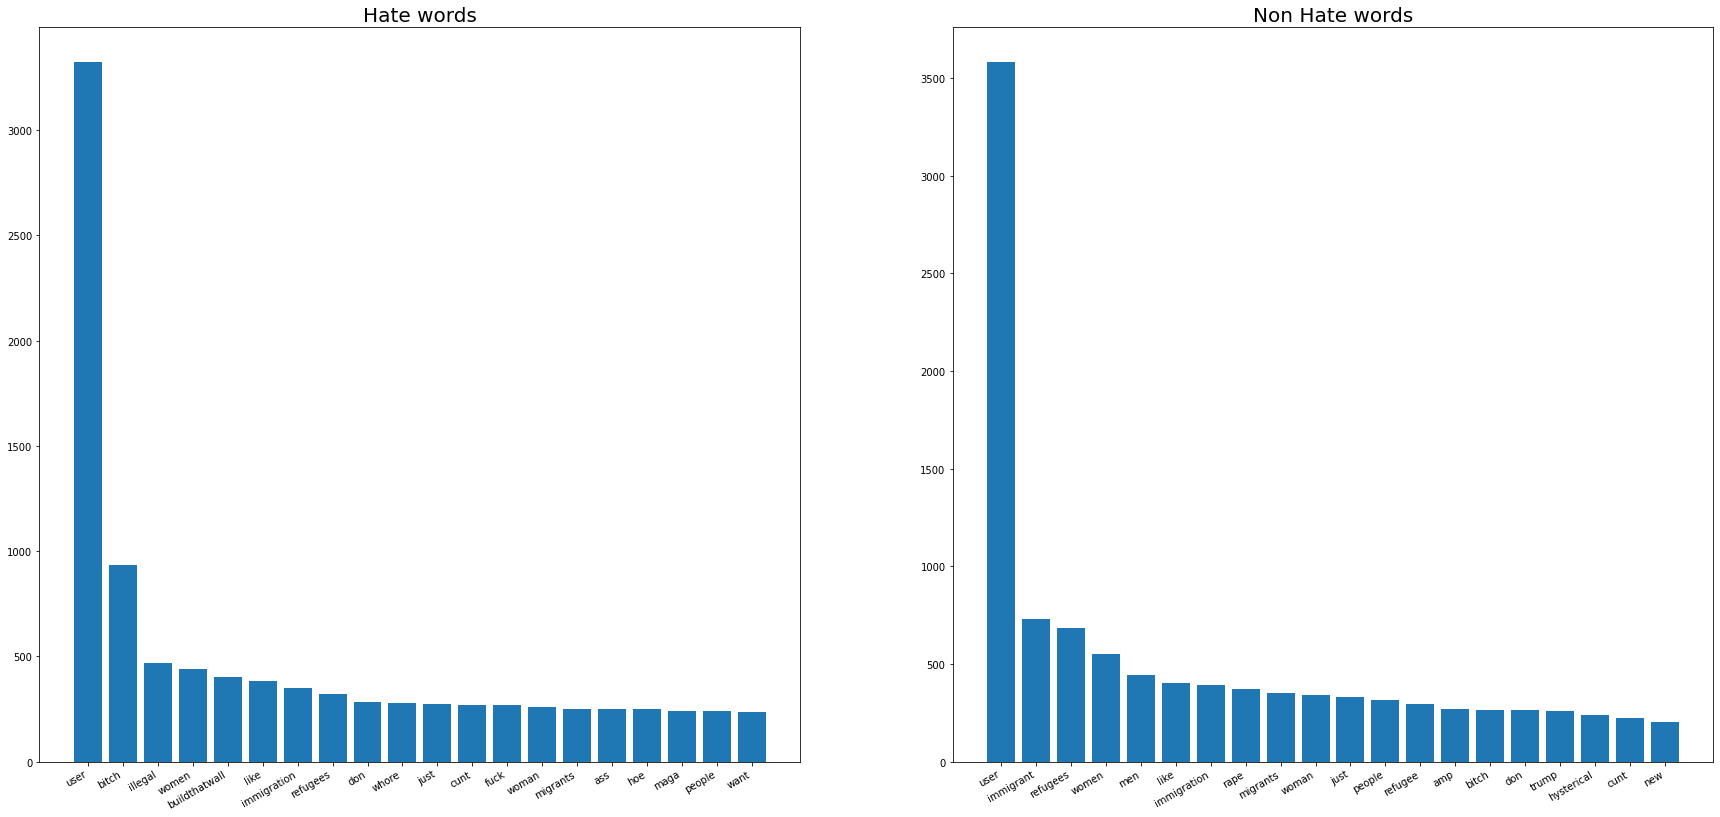

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(h1, h2)


ax1.set_title('Hate words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(nh1,nh2)
ax2.set_title('Non Hate words',fontsize=20);
fig.autofmt_xdate()

**Training the model and testing with macro averaged F1 score as evaluation metrics.**

Data Cleaning

In [78]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = hate_train_val[['tweet_text','isHate']]
test_data = hate_combo_test[['tweet_text','isHate']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [79]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Training the model and testing the model

In [80]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [81]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 48, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['isHate']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['isHate']).values, batch_size = 128)
print("f1 score is {}".format(f1_score*100))

Epoch 1/10
79/79 [==============================] - 38s 444ms/step - loss: 0.6394 - accuracy: 0.6252 - f1_m: 0.6253 - precision_m: 0.6253 - recall_m: 0.6253
Epoch 2/10
79/79 [==============================] - 38s 476ms/step - loss: 0.4535 - accuracy: 0.7828 - f1_m: 0.7828 - precision_m: 0.7828 - recall_m: 0.7828
Epoch 3/10
79/79 [==============================] - 38s 479ms/step - loss: 0.4127 - accuracy: 0.8125 - f1_m: 0.8125 - precision_m: 0.8125 - recall_m: 0.8125
Epoch 4/10
79/79 [==============================] - 38s 477ms/step - loss: 0.3809 - accuracy: 0.8255 - f1_m: 0.8255 - precision_m: 0.8255 - recall_m: 0.8255
Epoch 5/10
79/79 [==============================] - 38s 476ms/step - loss: 0.3541 - accuracy: 0.8356 - f1_m: 0.8356 - precision_m: 0.8356 - recall_m: 0.8356
Epoch 6/10
79/79 [==============================] - 38s 476ms/step - loss: 0.3242 - accuracy: 0.8555 - f1_m: 0.8555 - precision_m: 0.8555 - recall_m: 0.8555
Epoch 7/10
79/79 [==============================] - 37s 46

**F1 score for hate speach detection is generated with LSTM model**

#**Offensive Dataset**
## Pre-processing

In [92]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_off_train = pd.concat([off_train_text,off_train_label], axis=1)
df_off_val = pd.concat([off_val_text,off_val_label], axis=1)
df_off_test = pd.concat([off_test_text,off_test_label], axis=1)

In [93]:
off_combo_train = pd.merge(df_off_train,off_map, on='tweet_label')
off_combo_val = pd.merge(df_off_val,off_map, on='tweet_label')
off_combo_test = pd.merge(df_off_test,off_map, on='tweet_label')

In [94]:
off_train_val = pd.concat([off_combo_train,off_combo_val])

In [95]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(off_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

0

In [96]:
# offensive tweet
print("Offensive Tweet example :",off_train_val[off_train_val['offensive']=='offensive']['tweet_text'].values[0])
#Not-offensive Tweet 
print("Non offensive Tweet example :",off_train_val[off_train_val['offensive']=='not-offensive']['tweet_text'].values[0])


Offensive Tweet example : @user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 
Non offensive Tweet example : @user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen. 


Visualization

In [97]:
#creating different datasets for different classes
off_yes = train_off[train_off['offensive'] == 'offensive']['tweet_text']
off_no = train_off[train_off['offensive'] == 'not-offensive']['tweet_text']


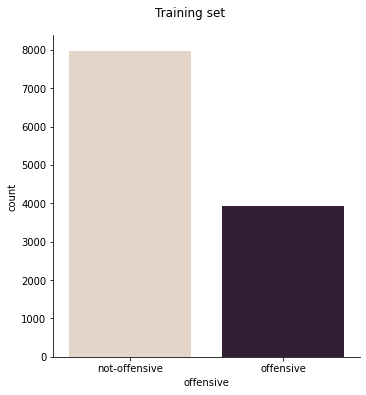

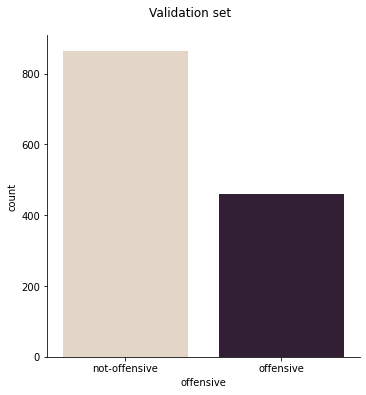

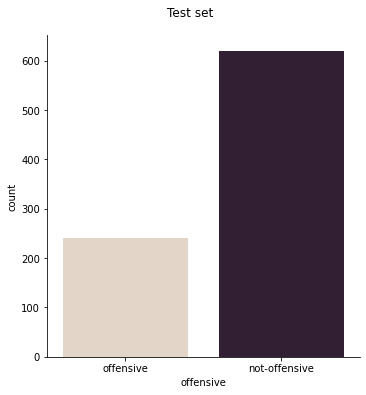

In [98]:
g = (sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("off_train.png")
# files.download("off_train.png")
plt.show()

v = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("off_val.png")
# files.download("off_val.png")
plt.show()

t = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("off_test.png")
#files.download("off_test.png")
plt.show()


wordcloud

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

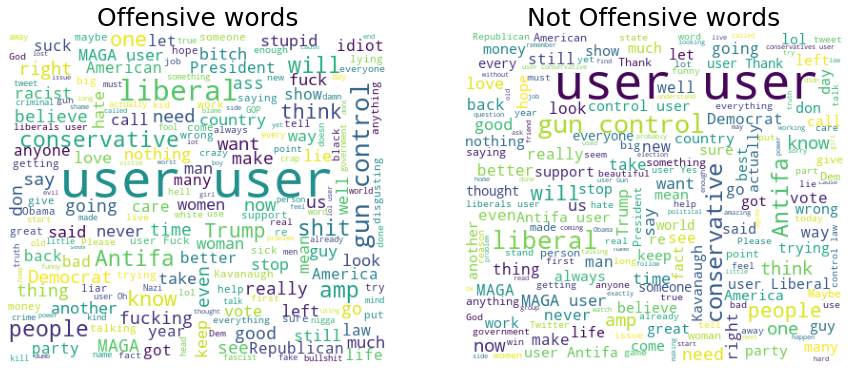

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(off_yes))
#wordcloud1.to_file('off_cloud.png')
#files.download('off_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Offensive words',fontsize=25);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(off_no))
#wordcloud2.to_file('non_off_cloud.png')
#files.download('non_off_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not Offensive words',fontsize=25);

 

In [100]:
# getting top 20 words in both sets of  Offensive dataset
top_offensive_words = get_top_n_words(off_yes)
top_nonOff_words = get_top_n_words(off_no)


of1 = [x[0] for x in top_offensive_words[:20]]
of2 = [x[1] for x in top_offensive_words[:20]]

no1 = [x[0] for x in top_nonOff_words[:20]]
no2 = [x[1] for x in top_nonOff_words[:20]]



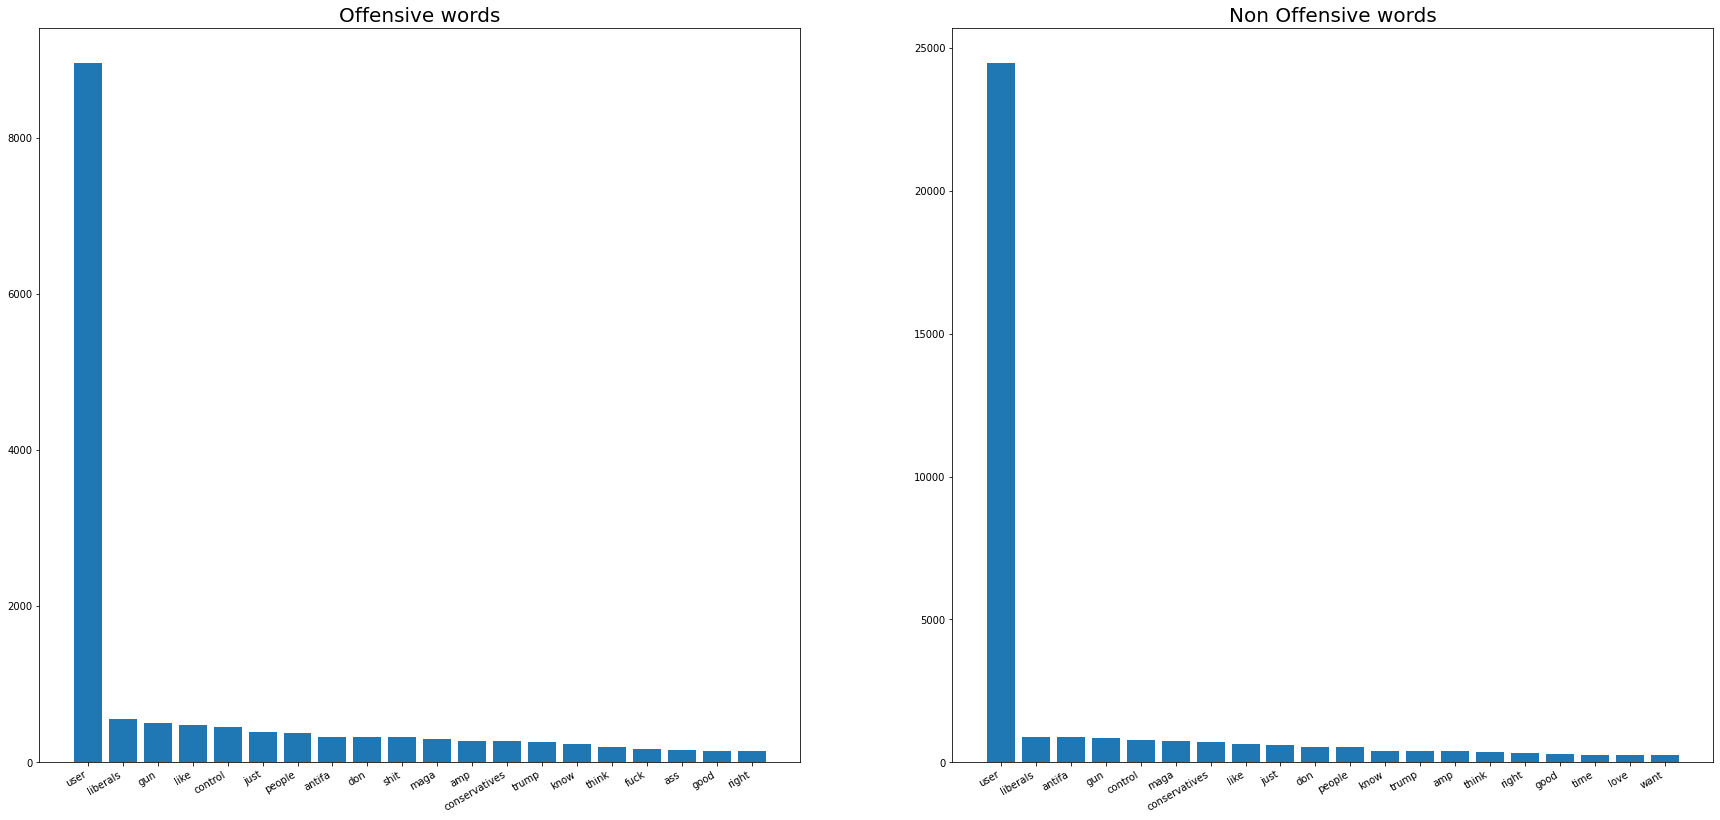

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(of1,of2)


ax1.set_title('Offensive words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(no1,no2)
ax2.set_title('Non Offensive words',fontsize=20);
fig.autofmt_xdate()





**Training the model and testing with macro averaged F1 score as evaluation metrics.**

Data Cleaning

In [102]:

#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = off_train_val[['tweet_text','offensive']]
test_data = off_combo_test[['tweet_text','offensive']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)

In [103]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Model Training and testing of model

In [104]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 47, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 650,754
Trainable params: 650,754
Non-trainable params: 0
_________________________________________________________________


In [355]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['offensive']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['offensive']).values, batch_size = 128)
print("f1 score is {}".format(f1_score*100))

Epoch 1/10
104/104 [==============================] - 43s 389ms/step - loss: 0.6278 - accuracy: 0.6713 - f1_m: 0.6713 - precision_m: 0.6713 - recall_m: 0.6713
Epoch 2/10
104/104 [==============================] - 40s 387ms/step - loss: 0.4707 - accuracy: 0.7843 - f1_m: 0.7843 - precision_m: 0.7843 - recall_m: 0.7843
Epoch 3/10
104/104 [==============================] - 41s 391ms/step - loss: 0.4232 - accuracy: 0.8149 - f1_m: 0.8150 - precision_m: 0.8150 - recall_m: 0.8150
Epoch 4/10
104/104 [==============================] - 41s 395ms/step - loss: 0.4184 - accuracy: 0.8183 - f1_m: 0.8183 - precision_m: 0.8183 - recall_m: 0.8183
Epoch 5/10
104/104 [==============================] - 40s 388ms/step - loss: 0.3934 - accuracy: 0.8296 - f1_m: 0.8296 - precision_m: 0.8296 - recall_m: 0.8296
Epoch 6/10
104/104 [==============================] - 41s 390ms/step - loss: 0.3825 - accuracy: 0.8371 - f1_m: 0.8371 - precision_m: 0.8371 - recall_m: 0.8371
Epoch 7/10
104/104 [==========================

**F1 score for offensive speach detection is generated with LSTM model**

# **Emotion Recognition Dataset**
## Pre-processing

In [105]:
#concatenating dataframe to make one dataset each for train, validation and test df

df_emo_train = pd.concat([emo_train_text,emo_train_label], axis=1)
df_emo_val = pd.concat([emo_val_text,emo_val_label], axis=1)
df_emo_test = pd.concat([emo_test_text,emo_test_label], axis=1)

#joining mapping dataset with train, validation and test datasets
emo_combo_train = pd.merge(df_emo_train,emo_map, on='tweet_label')
emo_combo_val = pd.merge(df_emo_val,emo_map, on='tweet_label')
emo_combo_test = pd.merge(df_emo_test,emo_map, on='tweet_label')


# concatenating train and validation datasets by row to make one complete training data
emo_train_val = pd.concat([emo_combo_train,emo_combo_val])

**Visualisation**

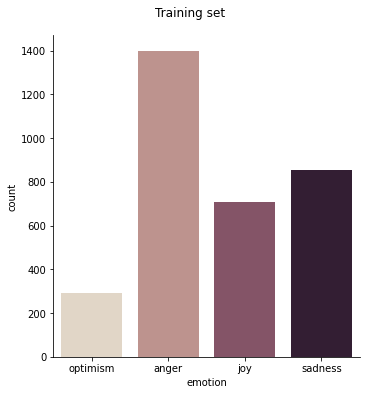

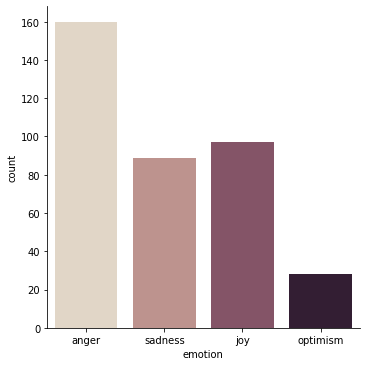

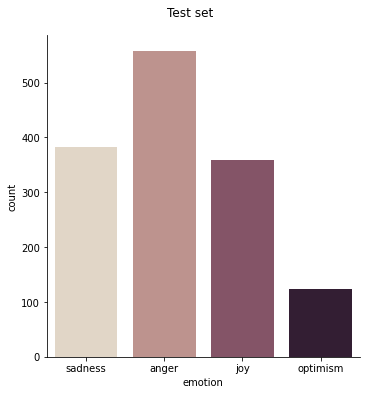

In [107]:

g = (sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_train))
g.fig.suptitle("Training set", y=1.05)
#g.savefig("emo_train1.png")
#files.download("emo_train1.png")
plt.show()

v = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_val)
# v.fig.suptitle("Validation set", y=1.05)
# v.savefig("emo_val.png")
#files.download("emo_val.png")
plt.show()

t = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emo_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("emo_test.png")
# files.download("emo_test.png")

plt.show()

In [109]:
#creating different datasets for different emotions
emo_sad = emo_combo_train[emo_combo_train['emotion'] == 'sadness']['tweet_text']
emo_anger = emo_combo_train[emo_combo_train['emotion'] == 'anger']['tweet_text']
emo_joy = emo_combo_train[emo_combo_train['emotion'] == 'joy']['tweet_text']
emo_opt = emo_combo_train[emo_combo_train['emotion'] == 'optimism']['tweet_text']

**Worldcloud**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

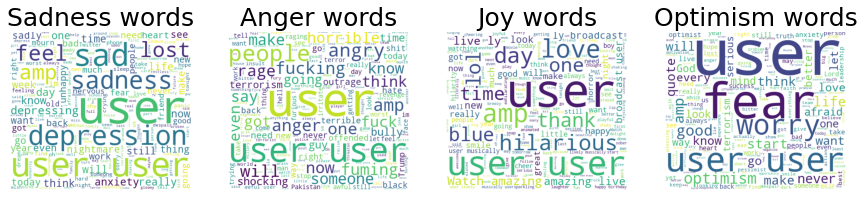

In [110]:
#creating wordclouds for different classes of Emotion
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[15, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(emo_sad))
#wordcloud1.to_file('sad_cloud.png')
#files.download('sad_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Sadness words',fontsize=25);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(emo_anger))
#wordcloud2.to_file('anger_cloud.png')
#files.download('anger_cloud.png')

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Anger words',fontsize=25);

wordcloud3 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(emo_joy))
#wordcloud3.to_file('joy_cloud.png')
#files.download('joy_cloud.png')

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Joy words',fontsize=25);

wordcloud4 = WordCloud( background_color='white',
                        width=400,
                        height=350).generate(" ".join(emo_opt))
#wordcloud4.to_file('opt_cloud.png')
#files.download('opt_cloud.png')

ax4.imshow(wordcloud4)
ax4.axis('off')
ax4.set_title('Optimism words',fontsize=25);


In [111]:
#getting top 20 words in each classification of Emotion dataset
top_sad_words = get_top_n_words(emo_sad)
top_angry_words = get_top_n_words(emo_anger)
top_joy_words = get_top_n_words(emo_joy)
top_op_words = get_top_n_words(emo_opt)

sa1 = [x[0] for x in top_sad_words[:20]]
sa2 = [x[1] for x in top_sad_words[:20]]

an1 = [x[0] for x in top_angry_words[:20]]
an2 = [x[1] for x in top_angry_words[:20]]

jo1 = [x[0] for x in top_joy_words[:20]]
jo2 = [x[1] for x in top_joy_words[:20]]

op1 = [x[0] for x in top_op_words[:20]]
op2 = [x[1] for x in top_op_words[:20]]

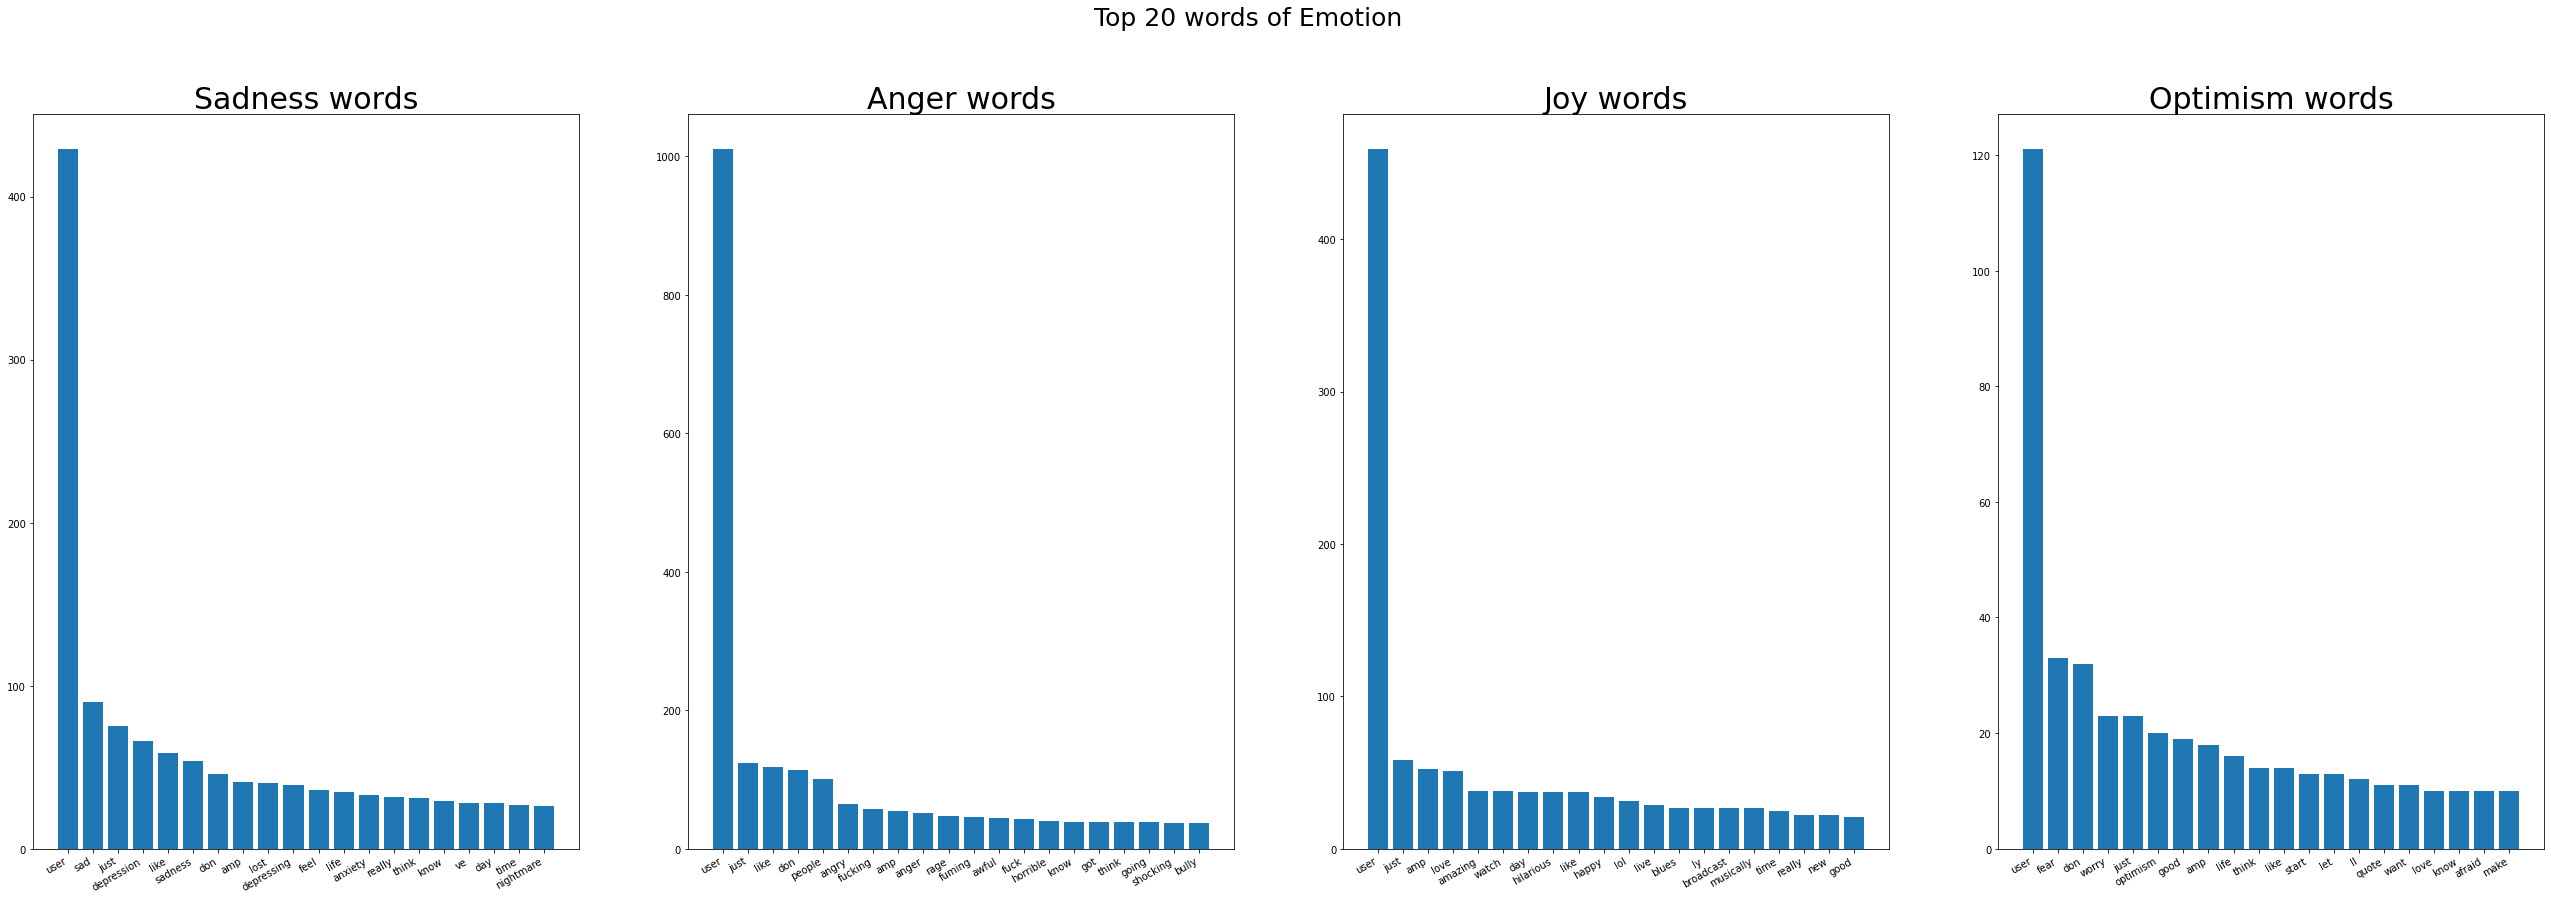

In [112]:
#visualization for top 20 words in each classification of Emotion

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[45, 15])
fig.suptitle('Top 20 words of Emotion',fontsize=25)
ax1.bar(sa1, sa2)
ax1.set_title('Sadness words',fontsize=30);
fig.autofmt_xdate()

ax2.bar(an1,an2)
ax2.set_title('Anger words',fontsize=30);
fig.autofmt_xdate()

ax3.bar(jo1,jo2)
ax3.set_title('Joy words',fontsize=30);
fig.autofmt_xdate()

ax4.bar(op1,op2)
ax4.set_title('Optimism words',fontsize=30);
fig.autofmt_xdate()

**Training the model and testing with macro averaged F1 score as evaluation metrics.**

In [113]:
#Data cleaning
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

train_data = emo_train_val[['tweet_text','emotion']]
test_data = emo_combo_test[['tweet_text','emotion']]

# Setting stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

# Function to expand tweet
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

# Function to process tweets
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet_text']
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data


wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

# pre-processing the tweets
train_data = clean_tweet(train_data, wordNetLemmatizer, porterStemmer)
test_data = clean_tweet(test_data, wordNetLemmatizer, porterStemmer)


In [114]:
# Tokenization
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Clean_tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Clean_tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Clean_tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)

Model Training and Model Testing

In [115]:
# Building the model
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(4, activation = 'softmax'))
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 651,268
Trainable params: 651,268
Non-trainable params: 0
_________________________________________________________________


In [366]:
# Training the model
history = model.fit(train_tweets, pd.get_dummies(train_data['emotion']).values, epochs = 10, batch_size = 128)

# Testing the model

#score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_tweets, pd.get_dummies(test_data['emotion']).values, batch_size = 128)
print("f1 score is {}".format(f1_score*100))

Epoch 1/10
29/29 [==============================] - 7s 173ms/step - loss: 1.3090 - accuracy: 0.4017 - f1_m: 0.0457 - precision_m: 0.1414 - recall_m: 0.0367
Epoch 2/10
29/29 [==============================] - 5s 174ms/step - loss: 1.1955 - accuracy: 0.4582 - f1_m: 0.1244 - precision_m: 0.4929 - recall_m: 0.0788
Epoch 3/10
29/29 [==============================] - 5s 179ms/step - loss: 0.8924 - accuracy: 0.6649 - f1_m: 0.5775 - precision_m: 0.8599 - recall_m: 0.4405
Epoch 4/10
29/29 [==============================] - 5s 173ms/step - loss: 0.6002 - accuracy: 0.7710 - f1_m: 0.7655 - precision_m: 0.8707 - recall_m: 0.6840
Epoch 5/10
29/29 [==============================] - 5s 174ms/step - loss: 0.4601 - accuracy: 0.8262 - f1_m: 0.8218 - precision_m: 0.8923 - recall_m: 0.7625
Epoch 6/10
29/29 [==============================] - 5s 181ms/step - loss: 0.3769 - accuracy: 0.8641 - f1_m: 0.8544 - precision_m: 0.9066 - recall_m: 0.8084
Epoch 7/10
29/29 [==============================] - 5s 174ms/ste

In [ ]:
**F1 score for Emotion Recognition is generated with LSTM model**